In [1]:
import numpy as np
import thewalrus as tw
import shutil
import multipartite_state as mss
import symplectic as sp 

np.set_printoptions(linewidth=320, edgeitems=999)


### Test implementation of single modes gates

Rotation matrix is self inverse

In [5]:
cs = mss.cluster_state()
cs.state.cov = cs.state.cov +1
cs.apply_squeezing(r= 0.2)
A = cs.state.cov.copy()
cs.apply_rotation_halfstate(-np.pi/2)
cs.apply_rotation_halfstate(np.pi/2)
np.allclose(A,cs.state.cov)

True

#### Comparison with thewalrus entire calculation

Apply squeezing works as expected

In [8]:
import multipartite_state as ms
cs = ms.cluster_state()
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth
cs.state.cov = cs.state.cov +1
S = tw.symplectic.squeezing(0.2)

F = tw.symplectic.expand(S,list(np.arange(N*ms,N*ms*depth)),N*ms*depth)
COV = cs.state.cov.copy()
cs.apply_squeezing(r= 0.2)
np.allclose(F@COV@F.conj().T,cs.state.cov)

True

Apply rotation works as expected

In [11]:
import multipartite_state as ms
cs = ms.cluster_state()
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth
cs.state.cov = cs.state.cov +1
R = tw.symplectic.rotation(-np.pi/8)

F = tw.symplectic.expand(R,np.arange(N*ms+1,N*ms*depth,2),N*ms*depth)
COV = cs.state.cov.copy()
cs.apply_rotation_halfstate(-np.pi/8)
np.allclose(F@COV@F.conj().T,cs.state.cov)

True

The strategie used works and save time by applying calculation only on needed element of the cov matrix

---

### Test implementation of the BS among different modes

In [12]:
import multipartite_state as ms
cs = ms.cluster_state()
cs.state.mu += 1
cs.state.cov +=1
cs.apply_beamsplitter(0) 
A = cs.state.cov
B = cs.state.mu

Apply beamsplitter works as expected

In [14]:
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth
indices = cs.BS_indices[0]
F = cs.BS(N = N*ms*depth,
                     modesA = indices[0],
                     modesB = indices[1])

C = np.eye(N*ms*depth*2)*1/2+1
M = np.zeros(N*ms*depth*2)+1
print(np.allclose(F@M,B))
print(np.allclose(F@C@F.conj().T,A))


True
True


---

### Test run_calculation
Compare each step of the run_calculation to the full matrix multiplication

In [2]:
import multipartite_state as ms
cs = ms.cluster_state()
cs.state.mu += 1
cs.state.cov +=1

COV = np.array(cs.state.cov)
MU = np.array(cs.state.mu)
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth

S = tw.symplectic.squeezing(0.6)
SQZ= tw.symplectic.expand(S,list(np.arange(N*ms,N*ms*depth)),N*ms*depth)

R = tw.symplectic.rotation(-np.pi/9)
ROT= tw.symplectic.expand(R,list(np.arange(N*ms+1,N*ms*depth,2)),N*ms*depth)

R2 = tw.symplectic.rotation(np.pi/7)
ROT2= tw.symplectic.expand(R2,list(np.arange(N*ms+1,N*ms*depth,2)),N*ms*depth)



COV = SQZ @ COV @ SQZ.conj().T
MU = SQZ @ MU

print("Squeezing")
cs.apply_squeezing(0.6)
print(np.allclose(cs.state.mu,MU))
print(np.allclose(cs.state.cov,COV))

COV = ROT @ COV @ ROT.conj().T
MU = ROT @ MU

print("Rotation 1")
cs.apply_rotation_halfstate(-np.pi/9)
print(np.allclose(cs.state.mu,MU))
print(np.allclose(cs.state.cov,COV))

for i in range(len(cs.BS_indices)):
    indices = cs.BS_indices[i]
    F = cs.BS(N = N*ms*depth,
                        modesA = indices[0],
                        modesB = indices[1])
    COV = F @ COV @ F.conj().T
    MU = F @ MU
    print(f"BS {i}")
    cs.apply_beamsplitter(i)
    print(np.allclose(cs.state.mu,MU))
    print(np.allclose(cs.state.cov,COV))
    if i == 0:
        COV = ROT2 @ COV @ ROT2.conj().T
        MU = ROT2 @ MU
        print("Rotation 2")
        cs.apply_rotation_halfstate(np.pi/7)
        print(np.allclose(cs.state.mu,MU))
        print(np.allclose(cs.state.cov,COV))


Squeezing
True
True
Rotation 1
True
True
BS 0
True
True
Rotation 2
True
True
BS 1
True
True
BS 2
True
True
BS 3
True
True


In [28]:
print(np.allclose(cs.state.mu,MU))
print(np.allclose(cs.state.cov,COV))

True
True


The simulation runs as expected

---

### Compare speed

In [2]:
%%timeit
cs= mss.cluster_state(spatial_depth=8,n=3,m=3,k=3)
cs.run_calculation(0.6)

5.84 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%timeit
cs= mss.cluster_state(spatial_depth=8,n=3,m=3,k=3)
n, m, k , N, ms, depth = cs.n, cs.m, cs.k, cs.N, cs.macronode_size, cs.spatial_depth

hbar = 1
MU = cs.state.mu
COV = cs.state.cov

indice_rot = np.arange(N*ms+1,N*ms*depth,2)
ROT = cs.P(N = N*ms*depth,
            modes = indice_rot,
            theta = -np.pi/2)
ROT2 = cs.P(N = N*ms*depth,
            modes = indice_rot,
            theta = np.pi/2)
indice_sqz = np.arange(N*ms,N*ms*depth)
SQZ = cs.S(N = N*ms*depth,
                    modes = indice_sqz,
                    r = 0.6)


COV = SQZ @ COV @ SQZ.conj().T
MU = SQZ @ MU

COV = ROT @ COV @ ROT.conj().T
MU = ROT @ MU

for i in range(len(cs.BS_indices)):
    indices = cs.BS_indices[i]
    F = cs.BS(N = N*ms*depth,
                        modesA = indices[0],
                        modesB = indices[1])
    COV = F @ COV @ F.conj().T
    MU = F @ MU
    if i == 0:
        COV = ROT2 @ COV @ ROT2.conj().T
        MU = ROT2 @ MU


9.69 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The implementation of the calculation in the class reduced nicely the time for the calculation 

### Generate the animation and plot state

In [1]:
import multipartite_state as mss
import numpy as np
cd = mss.cluster_state(spatial_depth= 3,structure="octo")
cd.run_calculation(0.6, gif=True, save=True)





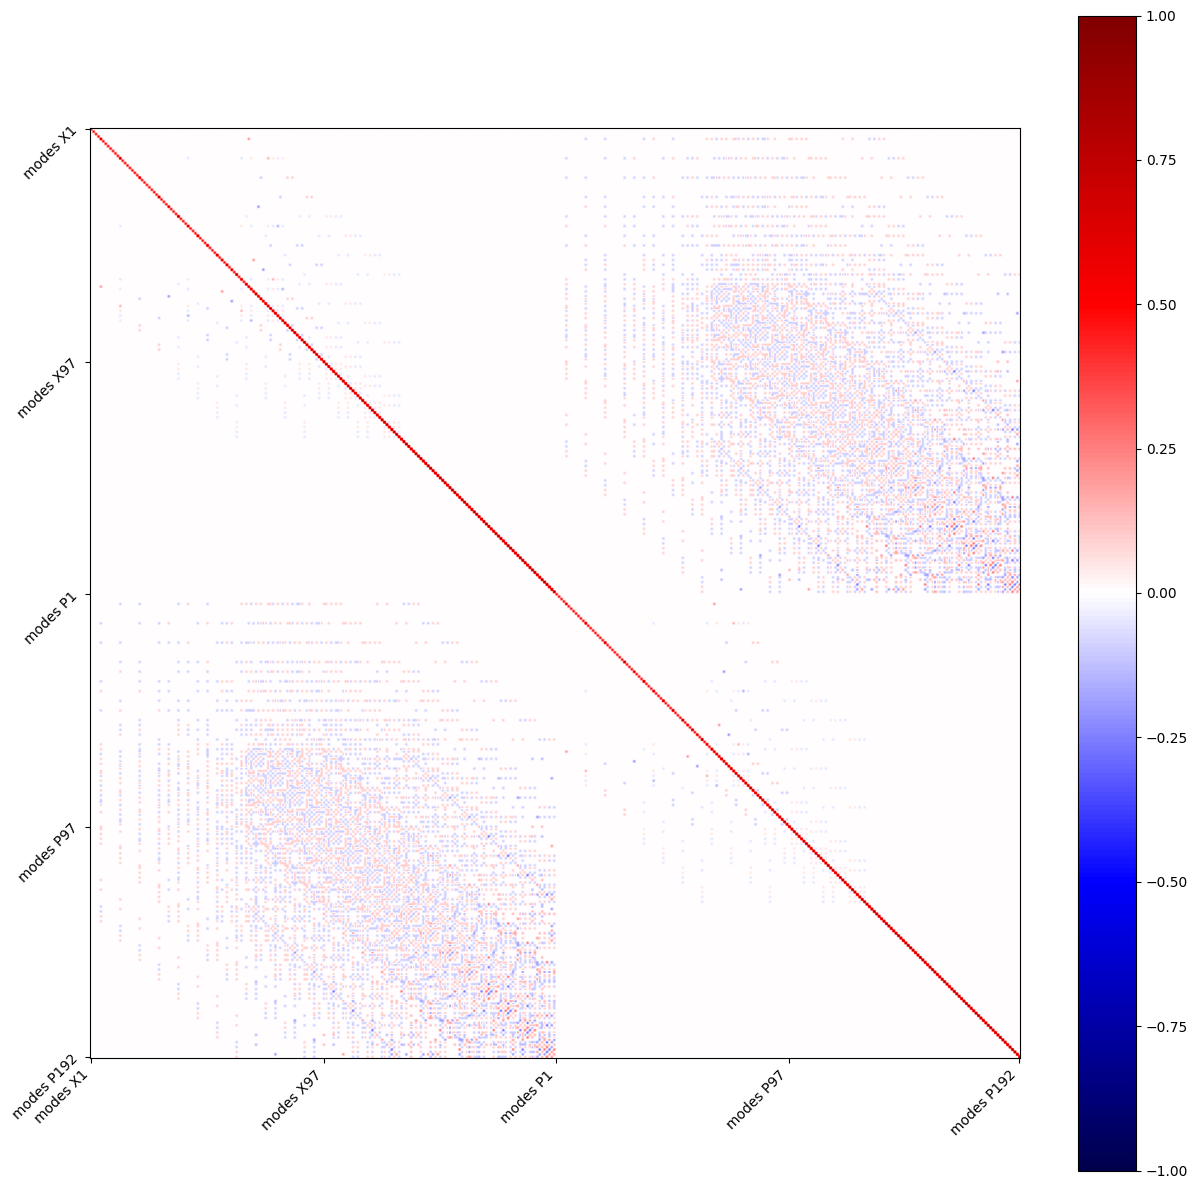

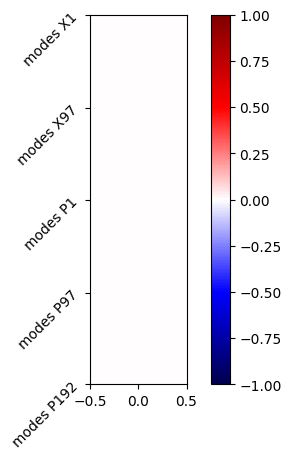

In [7]:
cd.state.plot_cov_matrix()
cd.state.plot_mean_matrix()

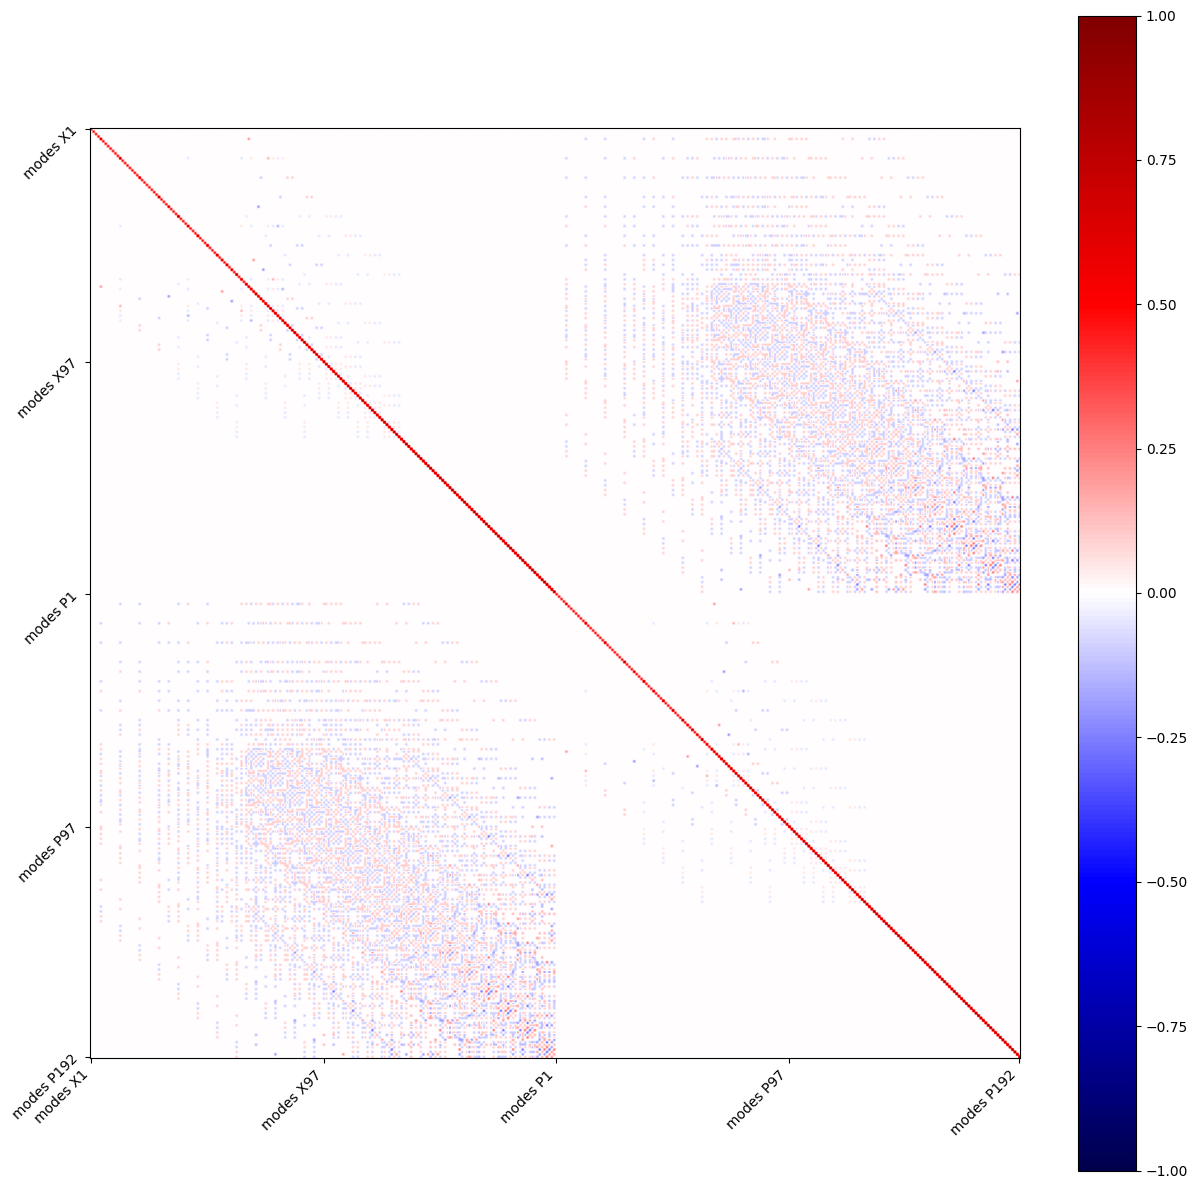

In [2]:
cd.open_calculation("Cluster_state_simulation.hdf5")
cd.state.plot_cov_matrix()

### Test of the measurement:

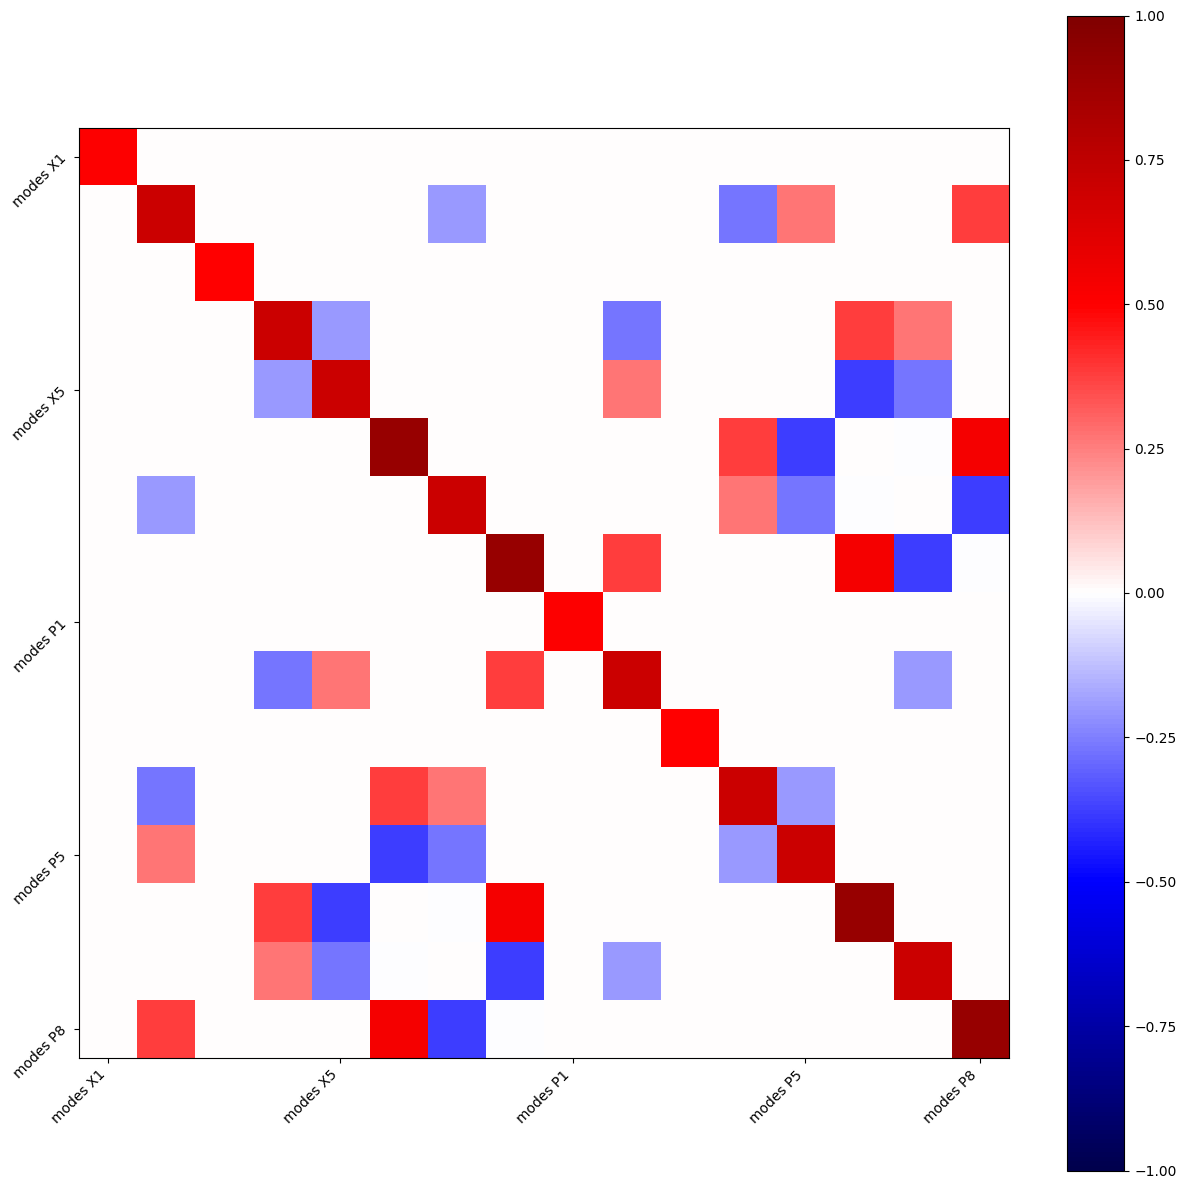

In [8]:
import multipartite_state as mss
import numpy as np
cd = mss.cluster_state(spatial_depth= 2, n = 2,m =1, k=1,structure="dual")
cd.run_calculation(0.6)
cd.state.plot_cov_matrix()

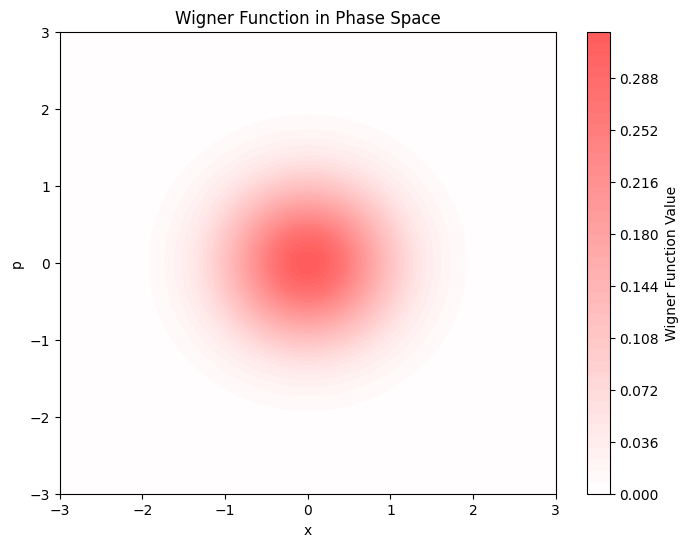

(array([5.13248694e-18, 2.42724177e-18]),
 array([[ 5.00000000e-01, -2.73057350e-50],
        [ 1.19833203e-50,  5.00000000e-01]]),
 array([-0.27758408,  0.28119454, -0.13113373,  0.83614928, -0.5988435 ,
         0.38184594, -0.24865141, -0.21034593, -0.26133937,  0.72475806,
        -0.89784047, -0.440146  , -0.13893046, -0.19139216]))

In [3]:
cd.measurement_gaussian(np.array([0,1,2,3,5,6,7]), np.array([0,0,0,0,np.pi/2,np.pi/2,np.pi/2]), plot=True)